# SWIFT VS SWALLOW
> Phân loại chim yến (swift) và chim én (swallow)
> Trong dự án này, tôi chỉ sử dụng các kiến trúc đã được "học" -train rồi và tận dụng lại các biến (parameters) được cải thiện chất lượng. Việc tự thiết kế một kiến trúc mới và thử nghiệm theo quan điểm cá nhân tôi là chưa phù hợp ở thời điểm hiện tại, do các vấn đề về độ lớn của dữ liệu (dữ liệu tôi sử dụng rất nhỏ), thời gian xử lý và cách cải thiện biến (fine-tune parameters) là rất phức tạp để thực hiện. Do vậy, tôi sẽ sử dụng các "pre-trained" models để giải quyết bài toán của mình. 

In [2]:
from fastai.vision.all import *

In [3]:
!ls

download.ipynb	fastai_model.ipynb


In [11]:
## Assign a path to our data:
home = '/path/to/your/project'
path = Path(f"{home}/swift_swallow/data/")

In [12]:
Path.BASE_PATH = path
path.ls()

(#3) [Path('train'),Path('models'),Path('test')]

In [13]:
## Check torch device:
torch.cuda.current_device()

0

## TẠO DỮ LIỆU
Đối với máy học sâu (deep learning - viết tắt DL), việc tạo tập dữ liệu là rất quan trọng để đảm bảo những yếu tố như:
1. Dữ liệu đầu vào phù hợp với kiến trúc được sử dụng (ví dụ: các mô hình pretrained kinh điển - resnet, vgg, googlenet... đều sử dụng dữ liệu hình ảnh với chiều dài, rộng là 224, một số kiến trúc mới sử dụng 256, 299, hoặc lớn hơn như 528, 600 - B6, B7 EfficientNet. Tất nhiên cũng có các kích cỡ nhỏ hơn như 16, 32).
2. Batch-size: số lượng hình ảnh được sử dụng cho một lần học (iteration). Tùy thuộc vào độ lớn của dữ liệu vs dung lượng của GPU của máy tính bạn sử dụng và độ lớn của model bạn sử dụng, batch-size của bạn có thể ảnh hưởng đến tốc độ/khả năng học của model. Các size cơ bản hay được sử dụng là 32, 64, tuy nhiên bạn có thể thu nhỏ hoặc làm to hơn số lượng này (8, 16 hoặc 128...). Một số điểm cần lưu ý giữa các cụm từ: batch-size (bs), iterations (iter), epoch trong DL:
    - epoch: 1 epoch là một lần model học toàn bộ số lượng ảnh trong tập dữ liệu - train/valid - của bạn (giả sử là tập dữ liệu train có n hình ảnh, 1 epoch chứa n hình ảnh)
    - batch-size: 1 bs là số lượng hình ảnh được sử dụng cho từng lần học dữ liệu của model. Do dữ liệu tất cả các hình ảnh là lớn nên model sẽ không thể học đồng thời được mà phải chia nhỏ thành từng giỏ (batch) để học dần. 
    - interation: 1 iteration là 1 lần học dữ liệu của model. Như vậy, 1 iteration tương ứng với 1 bath-size.
    
    như vậy nếu quy ra số lần học dữ liệu (iteration), thì 1 epoch sẽ được tính như sau:
       $epoch = round-up(\frac{n}{batch-size})$ interations
3. Augmentation: dữ liệu hình ảnh có thể được biến đổi như: xoay chiều (rotate), lật (flip), đổi độ sáng, tương phản (brightness, contrast), ...Chúng ta có thể định nghĩa sẵn các bước biến đổi này khi tạo tập dữ liệu.

### Sử dụng ImageDataLoaders

In [14]:
## Bạn có thể cài thêm gói nbdev để xem được phần tài liệu của các lớp, hàm:
#!pip install nbdev
doc(ImageDataLoaders)

class ImageDataLoaders [source] ImageDataLoaders ( * loaders , path = '.' , device = None ) :: DataLoaders 
 
 Basic wrapper around several DataLoader s with factory methods for computer vision problems 
 Show in docs

In [15]:
bs = 32
dls = ImageDataLoaders.from_folder(
    path,
    valid_pct=0.2,
    seed=42, 
    bs=bs,
    item_tfms=Resize(460),
    batch_tfms=[*aug_transforms(size=224, min_scale=0.75), Normalize.from_stats(*imagenet_stats)]
)

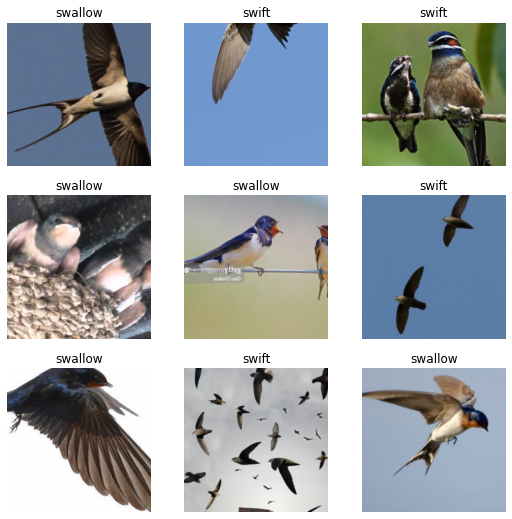

In [16]:
dls.show_batch(max_n=9)

**Diễn giải:**

ImageDataLoaders là một phương pháp tạo ra danh sách (interator) dữ liệu để thực việc học model. Ở đây, chúng ta sử dụng phương thức tạo danh sách dữ liệu từ folder chưa dữ liệu (`from_folder`). Thực thể này bao gồm các giá trị (properties) sau:

- path: là nơi (folder) chứa dữ liệu. Folder này được cấu trúc dưới dạng hierarchy như: train/test/valid --> tên các nhãn (classes) (ở đây chúng ta có folder con là swift và swawllow).
- train/valid: bạn có thể cấu trúc folder cho tập train/valid theo cách mà các thử thách ở Kaggle thường sắp xếp. Trong trường hợp này, chúng ta không có tập valid (ko có folder valid) nên sẽ không điền thông tin này. Thay vào đó chúng ta sẽ điền thông tin về `valid_pct` để lấy % của tập train làm valid.
- bs: batch-size, ở đây, bs mặc định là 64, tuy nhiên tôi đã chọn là 32 vì GPU của tôi khá khiêm tốn để chạy được model lớn như ResNet100 chẳng hạn. Khi bạn sử dụng bs từ 64 trở lên, nếu dùng GPU <= 8GB, bạn có thể bị tràn bộ nhớ GPU và cần phải restart lại notebook. Khi đó, hay giảm size của bs hoặc sử dụng các arc có kích thước nhỏ hơn (ResNet34, ResNet50 chẳng hạn).
- item_tfms: đây là biến đổi ảnh cho từng ảnh. Ở đây tôi chỉ sử dụng resize lại ảnh về cỡ 460 để thuận tiện hơn cho các bước augmentation tiếp theo cho từng batch một. Do kinh nghiệm của mình còn khiêm tốn nên tôi chưa thực sự nắm được lý do cho việc sử dụng cả `item_tfms` và `batch_tfms` ở đây. Theo như lý giải của tác giả, việc thực hiện biến đổi hình ảnh được thông qua 2 bước:
    + Bước 1: mở rộng dung size của ảnh (resize sang cỡ ảnh đủ lớn)
    + Bước 2: thao tác biến đổi ảnh khác nhau theo từng batch. 
    Theo tác giả thì theo cách biến đổi này, kết quả của việc biến đổi ảnh theo từng batch sẽ cho kết quả về chất lượng hình ảnh được tốt hơn so với cách thông thường là biến đổi ảnh trực tiếp từ ảnh. Một số lỗi hay gặp khi biến đổi trực tiếp từ ảnh như:
    + Ảnh sau biến đổi bị mất ảnh (ảnh sau biến đổi phải bổ sung thêm nền đen (padding zero)
    + Chất lượng ảnh (resolution) không thật sự tốt, ảnh bị mờ nhiều hơn
    + Ảnh khi xoay chiều có thể không được như ý.
    Thông tin chi chiết về cách phương pháp augmentation, xin xem tại [đây](https://docs.fast.ai/vision.augment)
- batch_tfms: đây là các bước biến đổi ảnh chính được thực hiện cho từng batch hình ảnh khi được học. Các bước biến đổi này có thể được thực hiện trên GPU để tăng tốc độ biến đổi. Ở đây tôi sử dụng resize về cỡ 224 và sử dụng tất cả các bước biến đổi ảnh mặc định. Ngoài ra, có biến đổi normalize lại các pixcel ảnh. 

Ngoài phương thức tạo dữ liệu từu folder, ImageDataLoads còn có các phương thức tạo dữ liệu khác như:
- from_name_func: Chúng ta có thể tạo 1 hàm lambda để tạo thu thập nhãn dựa vào tên của ảnh, trong đó, các nhãn được gắn với tên của hình ảnh. Ví dụ như: ảnh swift-train-12346.jpg được đặt ở trong folder data. 
- from_path_func: tương tự như trên nhưng áp dụng với đường dẫn.
- from_path_re: sử dụng regex để lấy được thông in về tập train/test/valid và nhãn từ đường dẫn tới ảnh.
- from_name_re: tương tự như trên nhưng áp dụng cho tên của ảnh.
- from_df: trong dữ liệu có một bảng dữ liệu chứa thông tin về đường dẫn của từng file ảnh thuộc tập train/test/valid và tương ứng với từng đường dẫn này là nhãn của ảnh. 
- form_csv: tương tự với from_df trong đó file chứa thông tin này được lưu dưới dạng csv.
- from_lists: tương tự dạng csv nhưng thông tin về đường dẫn, nhãn được lưu dưới dạng list.

### Sử dụng DataBlock

DataBlock là API xây dựng dataset và DataLoader. Với DataBlock, bạn có thể xây dựng dataset một cách tùy biến cho tất cả các loại dữ liệu của bạn như: hình ảnh (image), bảng biểu (tabular) hay chữ (text). Tất nhiên, điều này đồng nghĩa với việc bạn cần nắm rõ hơn được dữ liệu của bạn là gì, cách thức bạn muốn xây dựng tập dữ liệu của bạn. Bản thân tôi cũng còn rất mới mẻ về DL nên phần thông tin này sẽ đi qua các thông tin chính mà DataBlock yêu cầu:
1. Loại dữ liệu đầu vào/ra. 
2. Phương pháp nhặt, phân nhóm và gán nhãn dữ liệu .
3. Phương pháp biến đổi dữ liệu (nếu có)

- Getting the source items,
- Splitting the items into the training set and one or more validation sets,-
- Labelling the items,
- Processing the items (such as normalization), and
- Optionally collating the items into batches

Xây dựng DataLoader:

In [17]:
doc(get_image_files)

get_image_files [source] get_image_files ( path , recurse = True , folders = None ) 
 
 Get image files in path recursively, only in folders , if specified. 
 Show in docs

In [18]:
bird_db = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    item_tfms=Resize(460),
    batch_tfms=[*aug_transforms(size=224, min_scale=0.75), Normalize.from_stats(*imagenet_stats)]
)
dls = bird_db.dataloaders(path)

In [19]:
doc(ImageBlock)

ImageBlock [source] ImageBlock () 
 
 A TransformBlock for images of cls 
 Show in docs

**Diễn giải:**

1. Loại dữ liệu đầu vào/ra:
    - `blocks`: được sử dụng để xác định loại dữ liệu đầu vào và ra - mục đích sử dụng của loại dữ liệu này (x và y!). Trong đó `ImageBlock` là dữ liệu đầu vào dạng ảnh, còn `CategoryBlock` là dữ liệu đầu ra dạng phân loại. 

2. Phương pháp nhặt, phân nhóm và gán dữ liệu:
    - `get_items`: phương pháp nhặt dữ liệu, chúng ta sử dụng hàm `get_image_files` ở đây làm phương pháp nhặt dữ liệu dạng hình ảnh. Phương pháp này hỗ trợ việc phân loại hình ảnh theo nhóm (train/valid) nếu như folder có đặt chi tiết thành train và valid riêng biệt. Nếu không, bạn có thể chỉ chi tiết cách  phân nhóm hoặc DataBlock sẽ mặc định lấy 20% dữ liệu của bạn để làm tập valid.
    - `get_y`: phương pháp gán nhãn, sử dụng hàm `parent_label` để sử dụng folder mẹ làm nhãn của hình ảnh (có nghĩa là tất cả các ảnh được chứa trong cùng một folder ngay trên nó (folder mẹ) thì tên folder đó chính là nhãn của hình ảnh.
3. Phương pháp biến đổi dữ liệu:
    - `item_tfms`: phương pháp biến đổi dữ liệu cho từng ảnh
    - `batch_tfms`: phương pháp biến đổi dữ liệu cho từng batch một.
    

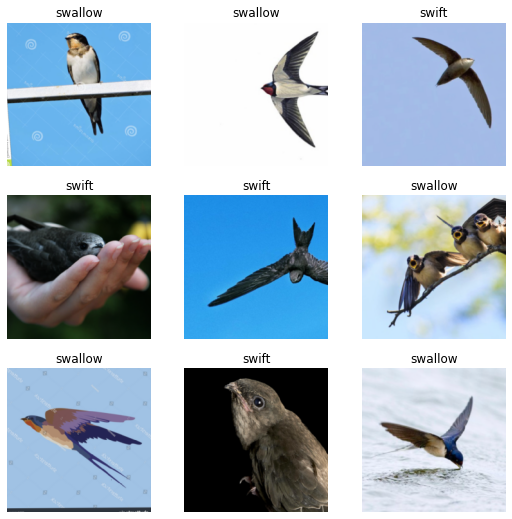

In [20]:
## Kiểm tra dữ liệu:
dls.show_batch(max_n=9)

Chúng ta cũng có thể xem thêm thông tin về các bước biến đổi dữ liệu cũng như các thông số:

In [21]:
print(imagenet_stats)

([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])


In [22]:
print(*aug_transforms(size=224, min_scale=0.75))

Flip -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 0.5}:
encodes: (TensorBBox,object) -> encodes
(TensorPoint,object) -> encodes
(TensorImage,object) -> encodes
(TensorMask,object) -> encodes
decodes:  Brightness -- {'max_lighting': 0.2, 'p': 1.0, 'draw': None, 'batch': False}:
encodes: (TensorImage,object) -> encodes
decodes:  RandomResizedCropGPU -- {'size': (224, 224), 'min_scale': 0.75, 'ratio': (1, 1), 'mode': 'bilinear', 'valid_scale': 1.0, 'p': 1.0}:
encodes: (TensorImage,object) -> encodes
decodes: 


Tạm thời chúng ta có thể sử dụng dữ liệu này để xây dựng mô hình. Hay tiếp tục với các phần sau!

## Đào tạo với RESNET

Resnet là kiến trúc DL rất nổi tiếng và được fastai sử dụng làm kiến trúc được đào tạo trước (pre-trained) chủ đạo. Ngoài ra, còn có biến thể của Resnet cũng được xây dựng sẵn trên fastai. Chúng ta sẽ cùng đi qua vài ví dụ để có thể làm quen dần với các kiến trúc đã được đào tạo trước.

### RESNET34

Việc sử dụng các kiến trúc DL được đào tạo trước giúp chúng ta đỡ tốn công sức cho 2 công việc chính sau:

1. Xây dựng một kiến trúc mạng DL mới cho từng vấn đề chúng ta gặp phải
2. Đào tạo và tinh chỉnh kiến trúc

Cả hai công việc trên đều tốn kém thời gian, công sức và đòi hỏi chúng ta phải thu thập dữ liệu đã gán nhãn đủ lớn để giúp kiến trúc DL được ổn định và không bị `overfit` (mô hình quá khớp). Do đó chúng ta có thể sử dụng lại các kiến trúc đã được xây dựng và được học, tinh chỉnh trên một lượng dữ liệu lớn, sử dụng lại các lớp (layer) có cùng tác vụ và chỉ cần thay đổi lớp cuối cùng của cấu trúc cũ với lớp phù hợp với tác vụ của chúng ta. 


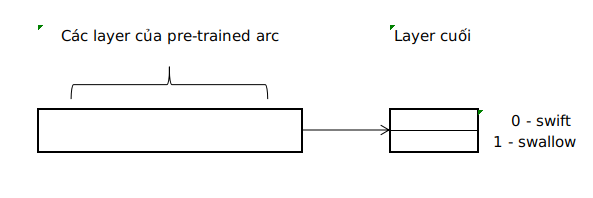

Ngoài ra, do các kiến trúc đã được đào tạo trên lượng dữ liệu lớn, do vậy, khi sử dụng cho các bài toán nhỏ như bài toán của chúng ta ở đây với số lượng ảnh tương đối nhỏ thì kết quả thu về thật sự vẫn rất đáng tin cậy. Hơn nữa, fastai cũng đã giúp chúng ta làm công việc thay đổi lớp cuối cùng để phù hợp với bài toán của chúng ta. Thay vì phải trực tiếp chỉnh sửa thì fastai đã xây dựng sẵn pipeline và chúng ta chỉ cần gọi tên kiến trúc cho mô hình của chúng ta mà thôi:

In [28]:
# Tạo một learner dựa vào cấu trúc pretrained.
from fastai.metrics import F1Score
learner = cnn_learner(dls, resnet34, metrics=[accuracy, F1Score()])

In [29]:
doc(cnn_learner)

cnn_learner [source] cnn_learner ( dls , arch , loss_func = None , pretrained = True , cut = None , splitter = None , y_range = None , config = None , n_out = None , normalize = True , opt_func = Adam , lr = 0.001 , cbs = None , metrics = None , path = None , model_dir = 'models' , wd = None , wd_bn_bias = False , train_bn = True , moms = (0.95, 0.85, 0.95) ) 
 
 Build a convnet style learner from dls and arch 
 Show in docs

**Lưu ý:**

Ở đây chúng ta tạo ra một kiến trúc mạng CNN ([mạng nơ-ron tích chập](https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-convolutional-neural-networks)) sử dụng lại kiến trúc RESNET34 (chỉ thay đổi layer cuối cùng). mạng CNN được sử dụng chính cho các bài toán liên quan đến dữ liệu dạng hình ảnh. 

Với mô hình đã xây dựng, có một số điểm chúng ta cần biết ở đây:
- dls: Thực thể dataloader: chính là dữ liệu được chúng ta tạo ra thông qua ImageDataLoader hoặc DataBlock.dataloaders.
- arch: Kiến trúc pre-trained. Với fastai, các kiến trúc của [RESNET](https://docs.fast.ai/vision.learner) và các biến thể. Tất nhiên, bạn có thể tạo riêng cho mình một kiến trúc riêng thông qua torch.nn. Với fastai, bạn chỉ cần nn.Sequential(...) để tạo ra một kiến trúc của riêng mình. Đồng thời, bạn phải sửa biến `pretrained=False`.
- metrics: là 1 hoặc nhiều chỉ số đo đạc được sử dụng để đánh giá chất lượng của mô hình đã xây dựng trong quá trình học. metrics là khác biệt với hàm loss (hàm "mất mát" - được dụng để tuối ưu  các tham số - parameters -của kiến trúc). Với fastai, bạn có thể sử dụng luôn `error_rate` và `accuracy` làm metrics (2 chỉ số nghịch đảo của nhau), với các chỉ số khác, bạn cần gọi hàm tương ứng. Ở đây tôi sử dụng 2 chỉ số: accuracy và F1.
- loss_func: [hàm "mất mát"](https://en.wikipedia.org/wiki/Loss_function) được sử dụng để đưa ra quyết định cho bài toán của chúng ta. Với bài toán phân loại này, hàm mất mát thường là hàm `cross-entropy` (hay thường được hiểu là hàm logarit mất mát `log loss`).
- opt_func: Hàm tối ưu (`optimization function` là hàm được dùng để tìm giá trị nhỏ nhất có thể của hàm mất mát, thông qua việc biến đổi các tham số của mô hình. Về cơ bản, hàm tối ưu được sử dụng trong học sâu là `SGD` viết tắt của [`Stochastic Gradient Discent`](https://en.wikipedia.org/wiki/Stochastic_gradient_descent). `Adam` là hàm mặc định ở đây, nó chính là một trong các biến thể của SGD.
- lr: `Learning rate` (tốc độ học) là siêu tham số luôn luôn đi cùng với hàm tối ưu. Nó là giá trị nhỏ giúp thay đổi giá trị các tham số của kiến trúc sau mỗi lần học (iteration) của mô hình.

Ngoài `dls`, `arch` và `metrics` ở đây chúng ta bắt buộc phải cung cấp, các tham số khác của hàm có thể cân nhắc để mặc định được. Và với tôi thì cũng chỉ cần cung cấp 3 tham số này trong bài toán hiện tại.

In [26]:
## Kiểm tra kiến trúc của mô hình:
learner.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

**Lưu ý:**

Đây chính là kiến trúc của RESNET34, bạn hay để ý ở dòng cuối cùng: 

`(8): Linear(in_features=512, *out_features=2*, bias=False)`

đây chính là phần được bổ sung vào cho kiến trúc thỏa mãn kết quả cuối cùng của đầu ra là 2 giá trị.

Giờ hãy thử bắt đầu cho mô hình học vs 10 epoch, sử dụng hàm `fit_one_cycle`

In [30]:
learner.fit_one_cycle(10)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,1.129633,0.678437,0.748634,0.813008,00:04
1,0.870066,0.544831,0.841530,0.861244,00:04
2,0.679050,0.324967,0.879781,0.898148,00:04
3,0.542706,0.263922,0.912568,0.925926,00:04
4,0.467172,0.241633,0.912568,0.927273,00:04
5,0.393632,0.233499,0.901639,0.918182,00:04
6,0.344126,0.204647,0.912568,0.927273,00:04
7,0.306976,0.189721,0.907104,0.923077,00:04
8,0.278176,0.184449,0.912568,0.927273,00:04
9,0.255312,0.179460,0.912568,0.927273,00:04


In [31]:
## Lưu kết qủa:
learner.save('stage-1')

Path('models/stage-1.pth')

**Một vài điều về phương pháp `fit_one_cycle`:**

Phương pháp này được xây dựng dựa vào bài viết của Leslie N. Smith (2015, 2017), bạn có thể đọc thêm tài liệu tại [đây](https://arxiv.org/abs/1708.07120) và [đây](https://arxiv.org/abs/1506.01186). Có rất nhiều phương pháp tinh chỉnh các tham số (`hyperparameter`) trong học sâu, trong đó `learning rate` (viết tắt `lr`) đặc biệt được chú trọng. `1cycle` là phương pháp được Smith nhắc tới khi nói về việc tăng và giảm $lr$ theo các chu kỳ (cycle) bắt đầu chu kỳ là $lr$ tối thiểu và thực hiện việc tăng $lr$ cho đến giữa chu kỳ là đạt mức $lr$ tối đa, sau đó lại giảm $lr$ từ $lr$ tối đa cho đến cuối chu kỳ thì quay lại $lr$ tối thiểu. Phương pháp này đã giúp tác giả sử dụng mộ lượng ít hơn rất nhiều số lần học của mô hình so sánh với số lượng lần học của các mô hình `state-of-the-art` (đỉnh cao) lúc bấy giờ. Để dễ hình dung được phương pháp này, đây là đồ thị về đường đi giá trị của $lr$ theo bài viết năm 2015 của tác giả: 

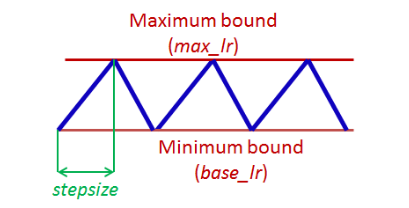
*ref: Smith (2015)*

Tác giả có tiếp tục cải thiện thêm phương pháp này, thay vì giá trị $lr$ thay đổi theo hình tam giác, phương pháp được cải thiện để giá trị $lr$ thay đổi theo hình cosine:
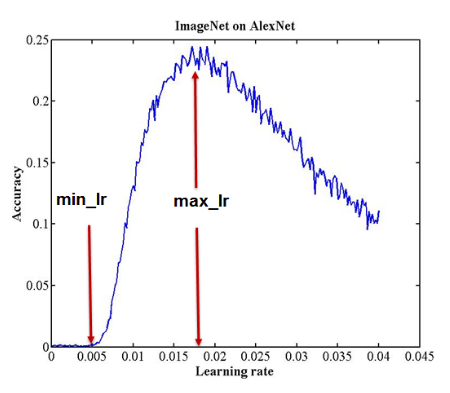
*ref: Smith, et al (2017)*

cho kết quả tốt hơn so với phương pháp cũ. Hiện fastai đang xây dựng `fit_one_cyle` theo phương pháp mới này.

Ngoài phương pháp trên, fastai còn cung cấp thêm 2 phương pháp hỗ trợ mô hình học dữ liệu rất thú vị khác là: `fine_tune` và `fit_flat_cos`. 

In [35]:
doc(learner.fine_tune)

Learner.fine_tune [source] Learner.fine_tune ( epochs , base_lr = 0.002 , freeze_epochs = 1 , lr_mult = 100 , pct_start = 0.3 , div = 5.0 , lr_max = None , div_final = 100000.0 , wd = None , moms = None , cbs = None , reset_opt = False ) 
 
 Fine tune with freeze for freeze_epochs then with unfreeze from epochs using discriminative LR 
 Show in docs

Với `fine_tune`: bạn chỉ cần điền số epoch bạn cần mô hình sẽ thử, công việc còn lại của fastai sẽ là 1) thử các giá trị $lr$ phù hợp cho 1 epoch đầu tiên; 2) sau đó sẽ bắt đầu việc học theo số lượng epoch của bạn mong muốn dựa theo kết quả đã tìm được từ bước 1. 

In [37]:
doc(learner.fit_flat_cos)

Learner.fit_flat_cos [source] Learner.fit_flat_cos ( n_epoch , lr = None , div_final = 100000.0 , pct_start = 0.75 , wd = None , cbs = None , reset_opt = False ) 
 
 Fit self.model for n_epoch at flat lr before a cosine annealing. 
 Show in docs

Với `fit_flat_cos`: có sự tương đồng với `fit_one_cyle`, được xây dựng dựa theo [Ilya Loshchilov et al.](https://arxiv.org/abs/1608.03983). Đại ý, $lr$ sẽ bắt đầu với giá trị lớn và không thay đổi trong vài epoch đầu tiên, sau đó $lr$ sẽ giảm dần và thay đổi theo hình cosine giống như phương pháp `fit_one_cycle`.

Để biết được phương pháp nào hiệu quả nhất, bạn chỉ có thể thực hành nhiều lần và đưa ra đút kết riêng cho cá nhân mình với từng loại bài toán, dữ liệu của mình! 

Ngoài ra, bạn cũng có thể tự tạo riêng cho mình một phương pháp hỗ trợ mô hình học riêng bằng `fit` và bạn có thể sử dụng nhiều cách thức khác nhau của `callbacks` để tính toán việc tăng/giảm $lr$ hoặc tạm dừng việc học nếu kết quả của hàm mất mát (loss) không được như ý...

### Kiểm tra kết quả

Kết quả ở trên với kiến trúc RESNET34 thực sự tuyệt vời! Chỉ với 10 epoch mà chúng ta có thể đạt được mức độ chính xác là 91.25% còn chỉ số F1 lên tới 92.7%. Rõ ràng với fastai chúng ta không cần phải làm nhiều để đạt được kết quả tốt. 

Bây giờ hay thử kiểm tra xem mô hình của chúng ta còn chưa tốt ở đâu:

In [38]:
interp = ClassificationInterpretation.from_learner(learner)
losses, idxs = interp.top_losses()
len(dls.valid_ds)==len(losses)==len(idxs)

True

In [39]:
doc(ClassificationInterpretation.from_learner)

Interpretation.from_learner [source] Interpretation.from_learner ( learn , ds_idx = 1 , dl = None , act = None ) 
 
 Construct interpretation object from a learner 
 Show in docs

Ở đây chúng ta sử dụng lớp ClassificationInterpretation và phương pháp `from_learner` để kiểm tra kết quả của chúng ta. Trước hết hay kiểm tra "ma trận nhầm lẫn" ([Confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix)) để nắm được con số dự đoán chính xác và không chính xác cho từng nhãn của mô hình đã được học ở bước trên:

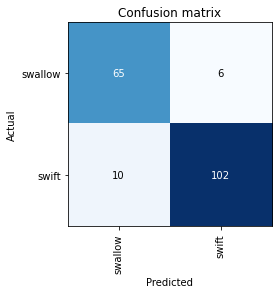

In [40]:
interp.plot_confusion_matrix()

Như vậy, chúng ta có tổng cộng 16 ảnh bị đoán sai, với 10 ảnh dự đoán là chim én nhưng thực tế lại là chim yến, và 6 anh được đoán là chim yến nhưng thực tế lại là chim én. Bây giờ hãy xem thực tế các ảnh bị đoán sai này trông như thế nào:

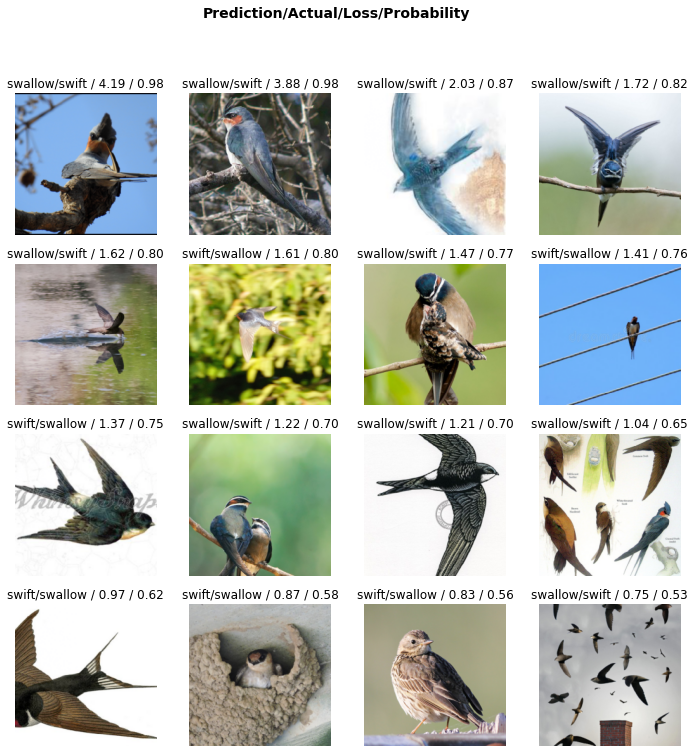

In [41]:
interp.plot_top_losses(16)

Có một vài kết luận ở đây khi nhìn vào các kết quả bị sai:

1. `Tree swift` là loại chim én rất đặc thù và rất hay bị nhầm lẫn với `barn swallow`. Phần lớn loài chim én đều được chụp lại khi chúng đang bay (do đặc thù hay bay của loài chim này). Còn chim én thì lại có rất nhiều ảnh chụp đang đậu trên cành cây. Loài `Yến cây` có nhiều đặc điểm hình dạnh tương đồng với loại `én đồng` nên có sự nhầm lẫn giữa 2 loài này với nhau. Có tới 5 ảnh của loại chim này bị nhầm với chim én. Đây là ảnh của chim yến cây:

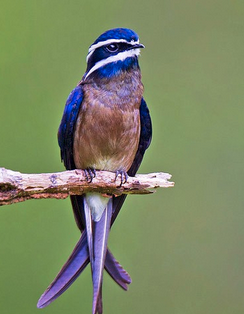

và đây:

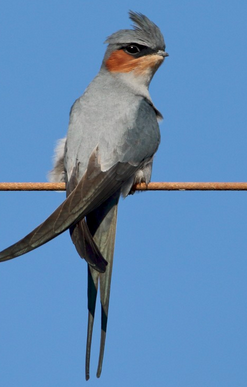

2. `House martin` (chim én xây tổ tường) có nét tương đồng với chim yến cổ trắng (`White-throated swift`). Đặc điểm tương đồng này được thấy rõ khi chúng cùng dang (sải) cánh  ra. Chúng sẽ có cùng vết trằng ở cổ và đuôi khiến đôi khi bị nhầm với nhau. Đây là chim én xây tổ tường:

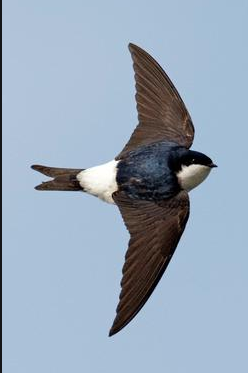

Đây là chim yến cổ trắng:

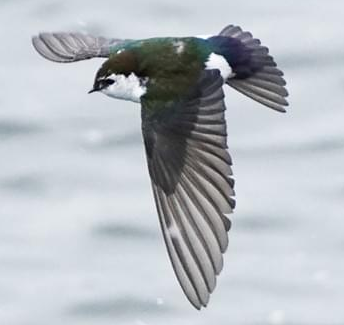

Có 3 ảnh ở đây đang bị nhầm lẫn giữa 2 loại chim này với nhau

3. Một vài đặc thù khác cho thấy phần lớn chim én được chụp khi chúng bay 1 mình, rất ý khi thấy chúng bay thành đôi. Tuy nhiên với chim én, chúng ta thấy có khá nhiều ảnh chim én đậu cùng với nhau hoặc bay cùng nhau. Do dó các ảnh có nhiều chim với nhau (hoặc đang đậu, hoặc đang bay) thường bị nhầm lẫn là chim én. Ở đây có 4 ảnh như vậy.

4. Thu thập sai dữ liệu: Không thể tránh khỏi việc thu thập sai dữ liệu trong quá trình xử lý dữ liệu, ở đây tôi thấy có 1 ảnh đang bị sai đó chính là ảnh này:

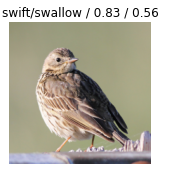

Tôi sẽ xóa ảnh này đi để dữ liệu được chính xác hơn.


### Tinh chỉnh mô hình

### Unfreezing Pre-trained model, fine-tuning and learning-rate

In [17]:
learner.unfreeze()
learner.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.835648,5.448223,0.382514,00:05


It doesn't look good with new train results after unfreezing pre-trained model.
Let's further find best learning rate here:

In [21]:
learner.load("stage-1")

**NOTE:**

the next step is to find the efficient learning rates that 

SuggestedLRs(lr_min=8.317637839354575e-05, lr_steep=9.12010818865383e-07)

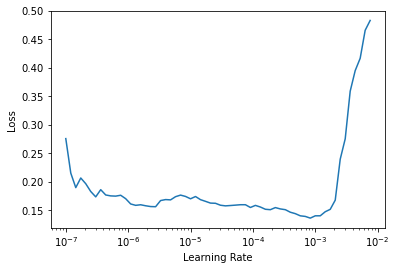

In [22]:
## find best learnig rate:
learner.lr_find()

After finding the right learning rate, let's unfreez it again and retrain it. This time, based on the learning rate finder, we'll slice learning rate between 2e-6 to 1e-4.

In [23]:
learner.unfreeze()
learner.fit_one_cycle(6, lr_max=slice(1e-6,8e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.140789,0.224944,0.060109,00:05
1,0.155556,0.288861,0.060109,00:05
2,0.158139,0.274033,0.081967,00:05
3,0.150515,0.267715,0.087432,00:05
4,0.137551,0.256441,0.076503,00:04
5,0.119532,0.256001,0.071038,00:04


**NOTE:**

It looks like the results look better here. Let's have 6 more circle to see how it'll go, if it's not good, let's reload stage-1 and unfreeze model and fit with less cycles.

In [34]:
# learner.fit_one_cycle(6, lr_max=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.121329,0.281597,0.085714,00:07
1,0.108418,0.283750,0.085714,00:06
2,0.109942,0.288984,0.091429,00:06
3,0.096244,0.286599,0.091429,00:06
4,0.089894,0.279662,0.091429,00:06
5,0.092233,0.277769,0.097143,00:06


In [24]:
## Save model after unfreeze layers and retrain weights:
learner.save("stage-2")

Path('models/stage-2.pth')

**RE-INTERPRETE THE RESULTS:**

In [25]:
interp_stg2 = ClassificationInterpretation.from_learner(learner)

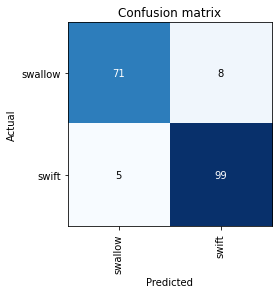

In [26]:
interp_stg2.plot_confusion_matrix()

In [27]:
##accuracy:
(84+87)/(84+87+5+7)

0.9344262295081968

## RESNET-50

In [34]:
learner = cnn_learner(dls, resnet50, metrics=error_rate)

In [35]:
## fit_one_cycle:
learner.fit_one_cycle(8)

epoch,train_loss,valid_loss,error_rate,time
0,0.965112,0.433052,0.131148,00:06
1,0.721527,0.260041,0.136612,00:06
2,0.554176,0.160182,0.060109,00:06
3,0.421401,0.186642,0.071038,00:12
4,0.341353,0.222586,0.071038,00:25
5,0.280021,0.191756,0.076503,00:12
6,0.233592,0.174829,0.071038,00:09
7,0.196609,0.168585,0.076503,00:07


In [36]:
learner.save("stage1-50")

Path('models/stage1-50.pth')

**Find lr:**

In [33]:
??learner.lr_find

Signature:
learner.lr_find(
    start_lr=1e-07,
    end_lr=10,
    num_it=100,
    stop_div=True,
    show_plot=True,
    suggestions=True,
)
Source:   
@patch
def lr_find(self:Learner, start_lr=1e-7, end_lr=10, num_it=100, stop_div=True, show_plot=True, suggestions=True):
    "Launch a mock training to find a good learning rate, return lr_min, lr_steep if `suggestions` is True"
    n_epoch = num_it//len(self.dls.train) + 1
    cb=LRFinder(start_lr=start_lr, end_lr=end_lr, num_it=num_it, stop_div=stop_div)
    with self.no_logging(): self.fit(n_epoch, cbs=cb)
    if show_plot: self.recorder.plot_lr_find()
    if suggestions:
        lrs,losses = tensor(self.recorder.lrs[num_it//10:-5]),tensor(self.recorder.losses[num_it//10:-5])
        if len(losses) == 0: return
        lr_min = lrs[losses.argmin()].item()
        grads = (losses[1:]-losses[:-1]) / (lrs[1:].log()-lrs[:-1].log())
        lr_steep = lrs[grads.argmin()].item()
        return SuggestedLRs(lr_min/10.,lr_steep)
File:      

SuggestedLRs(lr_min=0.00010000000474974513, lr_steep=2.75422871709452e-06)

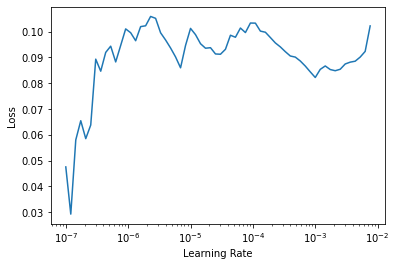

In [37]:
learner.lr_find()

In [37]:
learner.unfreeze()
learner.fit_one_cycle(10, lr_max=slice(6.309573450380412e-07, 0.00043651582673192023))

epoch,train_loss,valid_loss,error_rate,time
0,0.107520,0.220684,0.060109,00:07
1,0.106791,0.267370,0.071038,00:07
2,0.092749,0.272470,0.065574,00:07
3,0.077462,0.214519,0.049180,00:07
4,0.065444,0.239370,0.049180,00:07
5,0.067952,0.207074,0.038251,00:07
6,0.060400,0.189691,0.049180,00:07
7,0.058598,0.186252,0.038251,00:07
8,0.053605,0.183891,0.038251,00:07
9,0.059856,0.192166,0.043716,00:07


In [38]:
learner.save("stage2-50")

Path('models/stage2-50.pth')

In [39]:
interp = ClassificationInterpretation.from_learner(learner)

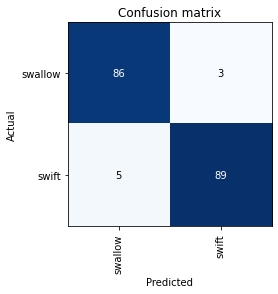

In [40]:
interp.plot_confusion_matrix()

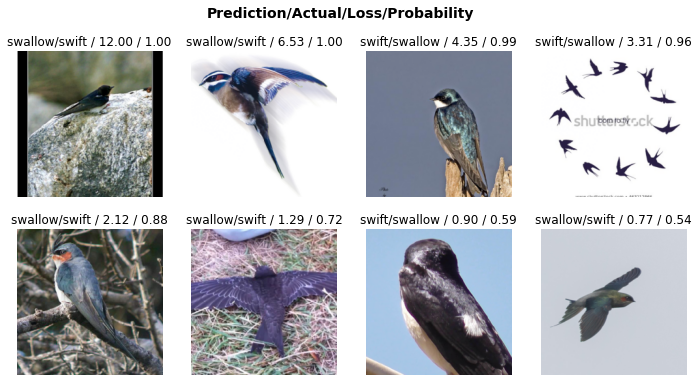

In [41]:
interp.plot_top_losses(8)

**NOTE:**
we can see that it's hard to recognize treeswifts and barn swallow at some views since they have similar shape when they're standing and similar flying style as well.

Let's try some other architectures (newly developed by fastai: xresnet; xresent-deep & xresnet-deeper to see any differences they make to this.

In [43]:
learner.save('stage2-50')

Path('models/stage2-50.pth')

# xRESNET:

In [10]:
learner = cnn_learner(dls, xresnet50, metrics=error_rate)

In [7]:
learner.fit_one_cycle(10)

epoch,train_loss,valid_loss,error_rate,time
0,1.104483,0.665283,0.278689,00:07
1,0.889694,0.648838,0.224044,00:05
2,0.845206,0.605756,0.229508,00:05
3,0.763565,0.548696,0.234973,00:05
4,0.672988,0.513306,0.191257,00:06
5,0.638785,0.471807,0.202186,00:06
6,0.577574,0.430423,0.169399,00:05
7,0.532678,0.451786,0.185792,00:05
8,0.486897,0.443982,0.202186,00:05
9,0.464668,0.451145,0.185792,00:05


In [8]:
interp = ClassificationInterpretation.from_learner(learner)

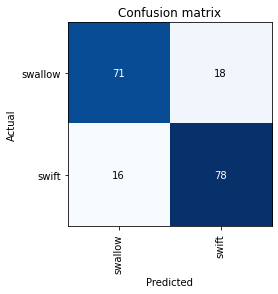

In [9]:
interp.plot_confusion_matrix()

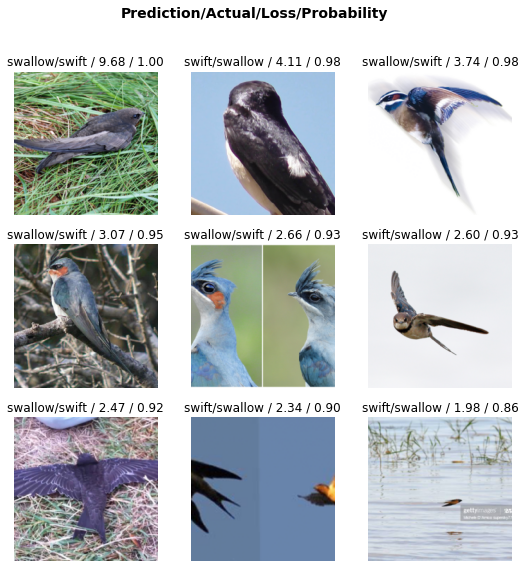

In [10]:
interp.plot_top_losses(9)

In [11]:
learner.save("stage1-x50")

Path('models/stage1-x50.pth')

In [11]:
learner.load("stage1-x50")

SuggestedLRs(lr_min=1.318256749982538e-07, lr_steep=1.0964781722577754e-06)

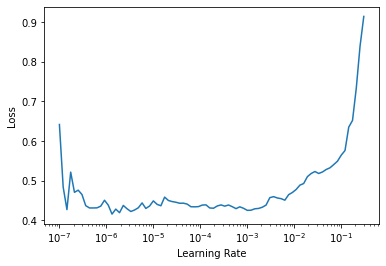

In [12]:
learner.lr_find()

In [13]:
learner.unfreeze()
learner.fit_one_cycle(6, lr_max=slice(9.12010818865383e-07, 1.318256749982538e-07))    

epoch,train_loss,valid_loss,error_rate,time
0,0.438584,0.439873,0.185792,00:08
1,0.427765,0.438531,0.185792,00:07
2,0.431225,0.441008,0.196721,00:07
3,0.418932,0.435654,0.185792,00:07
4,0.421612,0.434449,0.185792,00:07
5,0.422202,0.436851,0.185792,00:07


Based on the training, it doesn't look like xRESNET is good use.

Let's try deep & deeper xRESNET

In [14]:
learner = cnn_learner(dls, xresnet50_deep, metrics=error_rate)

In [22]:
learner.fit_one_cycle(20)

epoch,train_loss,valid_loss,error_rate,time
0,1.234699,0.726292,0.371585,00:06
1,1.113659,0.814082,0.284153,00:06
2,1.025010,1.097317,0.344262,00:06
3,0.916635,0.813829,0.311475,00:05
4,0.817120,0.633078,0.295082,00:05
5,0.779663,0.723271,0.284153,00:05
6,0.727677,0.722286,0.300546,00:05
7,0.657205,0.735125,0.300546,00:05
8,0.595359,0.605385,0.267760,00:05
9,0.553759,0.669066,0.289617,00:05


In [15]:
learner.save("stage1-x50_deep")

Path('models/stage1-x50_deep.pth')

In [23]:
learner.load("stage1-x50_deep")

RuntimeError: Error(s) in loading state_dict for Sequential:
	Missing key(s) in state_dict: "0.10.0.convpath.0.0.weight", "0.10.0.convpath.0.1.weight", "0.10.0.convpath.0.1.bias", "0.10.0.convpath.0.1.running_mean", "0.10.0.convpath.0.1.running_var", "0.10.0.convpath.1.0.weight", "0.10.0.convpath.1.1.weight", "0.10.0.convpath.1.1.bias", "0.10.0.convpath.1.1.running_mean", "0.10.0.convpath.1.1.running_var", "0.10.0.convpath.2.0.weight", "0.10.0.convpath.2.1.weight", "0.10.0.convpath.2.1.bias", "0.10.0.convpath.2.1.running_mean", "0.10.0.convpath.2.1.running_var", "0.11.0.convpath.0.0.weight", "0.11.0.convpath.0.1.weight", "0.11.0.convpath.0.1.bias", "0.11.0.convpath.0.1.running_mean", "0.11.0.convpath.0.1.running_var", "0.11.0.convpath.1.0.weight", "0.11.0.convpath.1.1.weight", "0.11.0.convpath.1.1.bias", "0.11.0.convpath.1.1.running_mean", "0.11.0.convpath.1.1.running_var", "0.11.0.convpath.2.0.weight", "0.11.0.convpath.2.1.weight", "0.11.0.convpath.2.1.bias", "0.11.0.convpath.2.1.running_mean", "0.11.0.convpath.2.1.running_var". 

SuggestedLRs(lr_min=5.754399353463669e-07, lr_steep=7.585775847473997e-07)

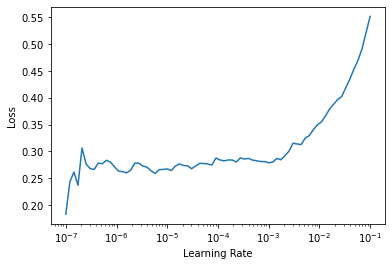

In [22]:
learner.lr_find()

In [17]:
learner.unfreeze()
learner.fit_one_cycle(10, lr_max=slice(1.0964781722577754e-06, 0.0003019951749593019))

epoch,train_loss,valid_loss,error_rate,time
0,1.236704,0.720743,0.333333,00:07
1,1.050963,0.719384,0.289617,00:07
2,0.990046,0.801886,0.322404,00:07
3,0.878589,0.678884,0.278689,00:07
4,0.822276,0.729805,0.278689,00:07
5,0.803536,0.592342,0.267760,00:07
6,0.755065,0.605545,0.251366,00:07
7,0.702199,0.624822,0.251366,00:07
8,0.649588,0.612735,0.262295,00:07
9,0.621836,0.624145,0.284153,00:07


In [18]:
learner = cnn_learner(dls, xresnet50_deeper, metrics=error_rate)

In [20]:
learner.fit_one_cycle(20)

epoch,train_loss,valid_loss,error_rate,time
0,0.465155,0.625097,0.273224,00:06
1,0.450099,0.606127,0.278689,00:06
2,0.476388,0.603168,0.240437,00:05
3,0.507000,0.725743,0.349727,00:06
4,0.516499,0.674369,0.240437,00:06
5,0.496295,0.673164,0.234973,00:05
6,0.489760,0.768032,0.278689,00:05
7,0.486999,0.644809,0.267760,00:06
8,0.468935,0.759174,0.240437,00:06
9,0.459300,0.726533,0.240437,00:05
